In [2527]:
import pyodbc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [2528]:
# Connect to the Database
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                        "Server=wd02;"
                        "Database=FootPrint;"
                        "Trusted_Connection=yes;")

# QUERY 01: Operations

In [2529]:
df = pd.read_sql_query("DECLARE @from date, @to date;\
    SELECT\
        @from = getdate()\
        ,@to = dateadd(day, 1, getdate());\
\
SELECT CONVERT(varchar,t.completedDateTime,100) Date, w.name warehouse, p.name project, oc.name operationCode, t.employee\
    FROM datex_footprint.Tasks t\
    JOIN datex_footprint.OperationCodes oc\
        ON oc.id = t.operationCodeId\
    JOIN datex_footprint.Warehouses w\
        ON w.id = t.warehouseId\
    JOIN datex_footprint.Projects p\
        ON p.id = t.projectId\
    WHERE t.completedDateTime >= @from AND t.completedDateTime < @to AND (t.employee != 'FootPrintService') AND (t.employee != 'Foot Print Service') and t.statusId = 2", cnxn)

In [2530]:
# Adding Hours
df['Hour'] = pd.to_datetime(df['Date']).dt.hour
df.head()

,Date,warehouse,project,operationCode,employee,Hour
0,Apr 1 2022 4:28PM,20,Sartorius Stedim North America,Receiving,Brittany Owen,16
1,Apr 1 2022 4:28PM,20,Sartorius Stedim North America,Receiving,Brittany Owen,16
2,Apr 1 2022 4:28PM,20,Sartorius Stedim North America,Receiving,Brittany Owen,16
3,Apr 1 2022 4:28PM,20,Sartorius Stedim North America,Receiving,Brittany Owen,16
4,Apr 1 2022 4:28PM,20,Sartorius Stedim North America,Receiving,Brittany Owen,16


# WAREHOUSE

In [2531]:
# Group By Warehouse
df_warehouse = df.groupby(['warehouse']).count()[['operationCode']]
df_warehouse.reset_index(inplace=True)
df_warehouse.head()

,warehouse,operationCode
0,10,1241
1,12,71
2,15,634
3,16,101
4,17,7


In [2532]:
# Pie Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.pie(activity, labels=warehouse)
#plt.show()

In [2533]:
# Bar Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(warehouse, activity)
#plt.show()

In [2534]:
# Save Data in JSON format
df_warehouse_index = df_warehouse.set_index(['warehouse'])
df_warehouse_index.to_json('data/warehouse.json')
df_warehouse_index.head()

,operationCode
warehouse,
10,1241
12,71
15,634
16,101
17,7


### All Operations type

In [2535]:
df_operation = df.groupby(['operationCode']).count()[['project']]
df_operation.reset_index(inplace=True)
df_operation.head()

,operationCode,project
0,Batch Move,168
1,Count,69
2,Create Inventory,1
3,DONE RECEIVING,21
4,DRIVER CHECK IN,20


In [2536]:
# Horizontal Bar Chart
values = df_operation['project']
operation = df_operation['operationCode']

#plt.subplots(figsize=(8,8))
#plt.barh(operation, values)
#plt.gca().invert_yaxis()
#plt.show()

In [2537]:
df_operation.rename(columns={"project": "Tasks"})
df_operation.head()

,operationCode,project
0,Batch Move,168
1,Count,69
2,Create Inventory,1
3,DONE RECEIVING,21
4,DRIVER CHECK IN,20


In [2538]:
# Save Data in JSON format
df_operation = df_operation.rename(columns={"project": "Tasks"})
df_operation_index = df_operation.set_index(['operationCode'])
df_operation_index.to_json('data/operations_type.json')
df_operation_index.head()

,Tasks
operationCode,
Batch Move,168
Count,69
Create Inventory,1
DONE RECEIVING,21
DRIVER CHECK IN,20


### Excluding Operations PICKING and RECEIVING

In [2539]:
df_operation_excluded = df_operation.loc[(df_operation["operationCode"] != 'Picking') &
                                         (df_operation["operationCode"] != 'Receiving')]

In [2540]:
# Save Data in JSON format
df_operation_excluded = df_operation_excluded.rename(columns={"project": "Tasks"})
df_operation_excluded_index = df_operation_excluded.set_index(['operationCode'])
df_operation_excluded_index.to_json('data/operations_type_excluded.json')
df_operation_excluded_index.head()

,Tasks
operationCode,
Batch Move,168
Count,69
Create Inventory,1
DONE RECEIVING,21
DRIVER CHECK IN,20


### Operations per Hour

In [2541]:
df_hours = df.groupby(['Hour']).count()[['operationCode']]
df_hours.reset_index(inplace=True)
df_hours.head()

,Hour,operationCode
0,6,1
1,7,16
2,8,243
3,9,214
4,10,423


In [2542]:
# Bar Chart
hour = df_hours['Hour']
activity = df_hours['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(hour, activity)
#plt.xticks(hour)
#plt.show()

In [2543]:
df_hours = df_hours.rename(columns={'operationCode': 'Operations'})
df_hours_index = df_hours.set_index(['Hour'])
df_hours_index.to_json('data/hours.json')
df_hours_index.head()

,Operations
Hour,
6,1
7,16
8,243
9,214
10,423


# PICKING

In [2544]:
# Filtered by Picking
df_picking = df[df['operationCode'] == 'Picking']

In [2545]:
# Grouped by Employee and Hour
df_picking_grouped = df_picking.groupby(['employee', 'Hour']).count()[['operationCode']]
df_picking_grouped.reset_index(inplace=True)
df_picking_grouped.head()

,employee,Hour,operationCode
0,Aisha Cooper,8,2
1,Aisha Cooper,15,11
2,Alejandro Aguirre,8,9
3,Alejandro Aguirre,12,16
4,Angel Luna,10,2


In [2546]:
# Pivot
df_picking_pivoted = df_picking_grouped.pivot(index='employee', columns='Hour', values='operationCode')
df_picking_pivoted = df_picking_pivoted.fillna(0)
df_picking_pivoted = df_picking_pivoted.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

df_picking_pivoted.head()

,7,8,9,10,11,12,13,14,15,16,17,18,19
employee,,,,,,,,,,,,,
Aisha Cooper,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0
Alejandro Aguirre,0.0,9.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Angel Luna,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brad Bacchetti,0.0,0.0,0.0,0.0,0.0,0.0,13.0,9.0,15.0,14.0,0.0,0.0,0.0
Carl Ambroise,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Save in JSON File

In [2547]:
# Save into JSON
pickers = df_picking_pivoted.T
pickers.to_json('data/pickers.json')
pickers.head()

employee,Aisha Cooper,Alejandro Aguirre,Angel Luna,Brad Bacchetti,Carl Ambroise,Carlos Chavez,Carlos Gomez,Edilberto Souza,Ernest Ferguson,Frantz Laman,...,Nelson Hurtado,Raul Bejarano,Reggie Bracken,Ronald Celis,Sujelin Soto-Orta,Wayne Gray,Wendy Medrano,William Trevino Trevino,Yaima Castillo,yudisel tubella
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
8,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,...,0.0,2.0,10.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10.0,0.0,...,0.0,2.0,5.0,0.0,1.0,17.0,19.0,0.0,0.0,0.0
10,0.0,0.0,2.0,0.0,0.0,0.0,6.0,0.0,2.0,0.0,...,3.0,0.0,0.0,12.0,0.0,17.0,33.0,0.0,19.0,11.0
11,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,...,0.0,3.0,0.0,11.0,0.0,0.0,60.0,0.0,64.0,10.0


### Picking By Warehouse Function

In [2548]:
# Picking Function
def picking_by_warehouse (warehouse):
    # Filter by warehouse
    df_w = df_picking[df_picking['warehouse'] == warehouse]
    
    # Grouped by Employee and Hour
    df_w_group = df_w.groupby(['employee', 'Hour']).count()[['operationCode']]
    df_w_group.reset_index(inplace=True)
    
    # Pivot
    df_w_pivot = df_w_group.pivot(index='employee', columns='Hour', values='operationCode')
    df_w_pivot = df_w_pivot.fillna(0)
    df_w_pivot = df_w_pivot.rename_axis(None, axis=1)
    
    # Save into JSON
    pickers_df = df_w_pivot.T
    file_name = f'data/pickers_w{warehouse}.json'
    pickers_df.to_json(file_name)

In [2549]:
# Save warehouse data into JSON files
picking_by_warehouse('10')
picking_by_warehouse('12')
picking_by_warehouse('15')
picking_by_warehouse('16')
picking_by_warehouse('18')
picking_by_warehouse('19')
picking_by_warehouse('20')
picking_by_warehouse('21')
picking_by_warehouse('22')

# RECEIVING

In [2550]:
# Filtered by Picking
receiving_df = df[df['operationCode'] == 'Receiving']
receiving_df.head()

,Date,warehouse,project,operationCode,employee,Hour
0,Apr 1 2022 4:28PM,20,Sartorius Stedim North America,Receiving,Brittany Owen,16
1,Apr 1 2022 4:28PM,20,Sartorius Stedim North America,Receiving,Brittany Owen,16
2,Apr 1 2022 4:28PM,20,Sartorius Stedim North America,Receiving,Brittany Owen,16
3,Apr 1 2022 4:28PM,20,Sartorius Stedim North America,Receiving,Brittany Owen,16
4,Apr 1 2022 4:28PM,20,Sartorius Stedim North America,Receiving,Brittany Owen,16


In [2551]:
# Grouped by Employee and Hour
receiving_group_df = receiving_df.groupby(['employee', 'Hour']).count()[['operationCode']]
receiving_group_df.reset_index(inplace=True)
receiving_group_df.head()

,employee,Hour,operationCode
0,Angela Briceno,16,14
1,Angela Pena,12,25
2,Angela Pena,15,2
3,Angela Pena,16,1
4,Baldomero Ramos,14,8


In [2552]:
# Pivot
receiving_pivot_df = receiving_group_df.pivot(index='employee', columns='Hour', values='operationCode')
receiving_pivot_df = receiving_pivot_df.fillna(0)
receiving_pivot_df = receiving_pivot_df.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

receiving_pivot_df.head()

,8,9,10,11,12,13,14,15,16,17,18
employee,,,,,,,,,,,
Angela Briceno,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0
Angela Pena,0.0,0.0,0.0,0.0,25.0,0.0,0.0,2.0,1.0,0.0,0.0
Baldomero Ramos,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,2.0,3.0,0.0
Brad Bacchetti,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,41.0,0.0,0.0
Brittany Owen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0


In [2553]:
# Save into JSON
receivers = receiving_pivot_df.T
receivers.to_json('data/receivers.json')
receivers.head()

employee,Angela Briceno,Angela Pena,Baldomero Ramos,Brad Bacchetti,Brittany Owen,Carl Ambroise,Carlos Chavez,Carly Potts,Casey Brown,Danielle Lucas,...,Juan Castro,Juan Morales,Justin Runsdorf,Luci Nicley,Martha Hurtado,Marzetta Bracken,Matthew Shipley,Sandra Vega,William Trevino Trevino,Yulieth Aguirre
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,21.0,1.0,0.0,0.0,7.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,...,0.0,54.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
12,0.0,25.0,0.0,0.0,0.0,0.0,38.0,0.0,0.0,1.0,...,0.0,58.0,0.0,0.0,0.0,26.0,0.0,0.0,10.0,0.0


# INVENTORY

In [2554]:
# Group By Operation Code and Warehouse
cycle_count_df = df.groupby(['operationCode', 'warehouse']).count()[['employee']]
cycle_count_df.reset_index(inplace=True)

In [2555]:
# Filtering by Count, Recount and Inventory Adjustment
cc_df = cycle_count_df.loc[(cycle_count_df["operationCode"] == 'Count') |
                           (cycle_count_df["operationCode"] == 'Recount') |
                           (cycle_count_df["operationCode"] == 'Inventory Adjustment')]

cc_df = cc_df.rename(columns={'employee': 'count'})

In [2556]:
cc_df_pivot = cc_df.pivot(index='operationCode', columns='warehouse', values='count')

In [2557]:
try:
    cc_df_pivot.rename({'Count': 'Inventory Counts'}, axis='index', inplace=True)
except:
    print('Operation COUNT does not exist yet')
    
try:
    cc_df_pivot.rename({'Recount': 'Discrepancies'}, axis='index', inplace=True)
except:
    print('Operation DISCREPANCIES does not exist yet')
    
try:
    cc_df_pivot.rename({'Inventory Adjustment': 'Inventory Adjustments'}, axis='index', inplace=True)
except:
    print('Operation INVENTORY ADJUSTMENT does not exist yet')

In [2558]:
cc_df_pivot = cc_df_pivot.fillna(0)
cc_df_pivot.to_json('data/cycle_count.json')
cc_df_pivot.head()

warehouse,10,15,18,19,20,21
operationCode,,,,,,
Inventory Counts,23.0,21.0,0.0,2.0,23.0,0.0
Inventory Adjustments,3.0,0.0,2.0,15.0,3.0,3.0
Discrepancies,0.0,0.0,0.0,0.0,3.0,0.0


# QUERY 02: Open Outbounds

In [2559]:
df_02 = pd.read_sql_query("SELECT DISTINCT w.name warehouse, p.name project, s.lookupCode shipment_number, s.createdSysDateTime\
    FROM datex_footprint.shipments s\
    LEFT JOIN datex_footprint.ShipmentOrderLookup sol\
        on sol.shipmentId = s.id\
    LEFT JOIN datex_footprint.orders o\
        on o.id = sol.orderId\
    LEFT JOIN datex_footprint.Projects p\
        on p.id = o.projectId\
    LEFT JOIN datex_footprint.warehouses w\
        on w.id = isnull(s.actualWarehouseId, s.expectedWarehouseId)\
    WHERE s.statusId in (1, 2, 4) and s.typeId = 2\
    ORDER BY createdSysDateTime", cnxn)

In [2560]:
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447


In [2561]:
df_02['age_order'] = pd.Timestamp.now() - df_02['createdSysDateTime']
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime,age_order
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1710 days 10:37:24.554086
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,914 days 08:56:23.608086
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,869 days 03:09:48.958086
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,800 days 06:26:20.688086
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,800 days 06:26:20.304086


In [2562]:
df_02['age_order_days'] = df_02['age_order'].dt.components['days']
df_02['age_order_hours'] = df_02['age_order'].dt.components['hours']
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime,age_order,age_order_days,age_order_hours
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1710 days 10:37:24.554086,1710,10
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,914 days 08:56:23.608086,914,8
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,869 days 03:09:48.958086,869,3
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,800 days 06:26:20.688086,800,6
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,800 days 06:26:20.304086,800,6


In [2563]:
bins =[-1,1,2,3,7,30,60, 90,365, 730,10000]
bin_names = ['24 Hours', '48 Hours', '72 Hours', '1 Week', '1 Month', '2 Months', '3 Months', '1 Year', '2 Years', 'More than 2 years']

df_02['age_group'] = pd.cut(df_02['age_order_days'], bins, labels=bin_names)

In [2564]:
df_02_grouped = df_02.groupby(['age_group'])[['project']].count()

In [2565]:
df_02_grouped = df_02_grouped.rename(columns={'project': 'orders'})

In [2566]:
df_02_grouped

,orders
age_group,
24 Hours,728
48 Hours,179
72 Hours,108
1 Week,314
1 Month,933
2 Months,670
3 Months,587
1 Year,2218
2 Years,1035


### Save in JSON File

In [2567]:
open_outbounds = df_02_grouped
open_outbounds.to_json('data/open_outbounds.json')
open_outbounds

,orders
age_group,
24 Hours,728
48 Hours,179
72 Hours,108
1 Week,314
1 Month,933
2 Months,670
3 Months,587
1 Year,2218
2 Years,1035


<AxesSubplot:ylabel='age_group'>

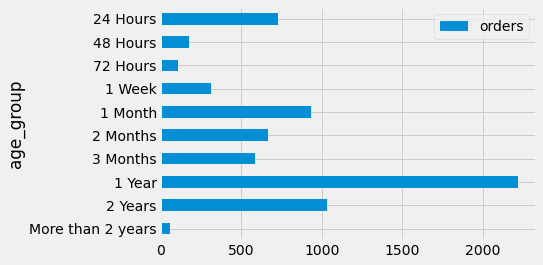

In [2568]:
df_02_grouped = df_02_grouped.iloc[::-1]
df_02_grouped.plot.barh()

# QUERY 3: Picking Performance (Orders and Waves)

In [2569]:
df03 = pd.read_sql_query("DECLARE @from date, @to date;\
                          SELECT @from = getdate(), @to = dateadd(day, 1, getdate());\
    SELECT t.completedDateTime Date, oc.name Operation, w.name Warehouse,\
           p.name Project, m.lookupCode Material, employee Employee, s.lookupCode Shipment, isnull(s.waveId, ps.waveId) Wave,\
           ordersPerWave.shipmentsCount, lc.name Location\
    FROM datex_footprint.Tasks t\
        join datex_footprint.OperationCodes oc\
            on oc.id = t.operationCodeId\
        left join datex_footprint.Warehouses w\
            on w.id = t.warehouseId\
        left join datex_footprint.Projects p\
            on p.id = t.projectId\
        left join datex_footprint.Materials m\
            on m.id = t.materialId\
        left join datex_footprint.Shipments s\
            on s.id = t.shipmentId\
        left join datex_footprint.PickSlips ps\
            on ps.id = t.pickSlipId\
        left join datex_footprint.LocationContainers lc\
            on lc.id = t.actualSourceLocationId\
        outer apply (\
            select\
                count(distinct tt.shipmentId) shipmentsCount\
                from datex_footprint.waves ww\
                    inner join datex_footprint.PickSlips ppss\
                    inner join datex_footprint.tasks tt\
                        on tt.operationCodeId = 8 and tt.pickSlipId = ppss.id\
                        on ppss.waveId = ww.id\
                where ww.id = isnull(s.waveId, ps.waveId)) ordersPerWave\
    where t.completedDateTime >= @from and t.completedDateTime < @to and t.statusId = 2\
    and t.operationCodeId in (8, 39, 2064, 2065, 2066) and t.employee != 'Foot Print Service'\
    order by s.lookupCode, t.completedDateTime", cnxn)

In [2570]:
df03.tail(3)

,Date,Operation,Warehouse,Project,Material,Employee,Shipment,Wave,shipmentsCount,Location
2407,2022-04-01 17:19:33.253,Scanned Shipment,15,"Virtus Pharmaceuticals, LLC",None,Haydee Moreno,VT80170162,232932.0,5,None
2408,2022-04-01 17:19:57.273,Picking,15,"Virtus Pharmaceuticals, LLC",76439035890,Haydee Moreno,VT80170162,232932.0,5,06-02-02-A
2409,2022-04-01 17:20:03.257,Picking Completed,15,"Virtus Pharmaceuticals, LLC",None,Haydee Moreno,VT80170162,232932.0,5,None


In [2571]:
# Order Columns
df03 = df03[['Warehouse', 'Project', 'Wave', 'Shipment', 'Date', 'Operation', 'Employee',
             'Location', 'shipmentsCount', 'Material']]

### Filter by Shipments

In [2572]:
# Filter by Orders only
df03_orders = df03.loc[(df03['Operation']=='Picking') |
                       (df03['Operation']=='Scanned Shipment') |
                       (df03['Operation']=='Picking Completed')]

df03_orders = df03_orders[['Warehouse', 'Project', 'Shipment', 'Date', 'Operation', 'Employee', 'Location']]

df03_orders.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location
245,10,ISDIN Corporation,0085560507,2022-04-01 09:35:31.840,Scanned Shipment,Wayne Gray,None
246,10,ISDIN Corporation,0085560507,2022-04-01 09:43:47.817,Picking,Wayne Gray,33-04-01-B
247,10,ISDIN Corporation,0085560507,2022-04-01 09:44:17.817,Picking Completed,Wayne Gray,None
248,10,ISDIN Corporation,0085560683,2022-04-01 09:44:20.660,Scanned Shipment,Wayne Gray,None
249,10,ISDIN Corporation,0085560683,2022-04-01 09:46:33.777,Picking,Wayne Gray,34-06-01-B


In [2573]:
# Create a new column with the time difference between rows
df03_orders['PickingTime'] = df03_orders['Date'].diff()
df03_orders.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime
245,10,ISDIN Corporation,0085560507,2022-04-01 09:35:31.840,Scanned Shipment,Wayne Gray,None,NaT
246,10,ISDIN Corporation,0085560507,2022-04-01 09:43:47.817,Picking,Wayne Gray,33-04-01-B,0 days 00:08:15.977000
247,10,ISDIN Corporation,0085560507,2022-04-01 09:44:17.817,Picking Completed,Wayne Gray,None,0 days 00:00:30
248,10,ISDIN Corporation,0085560683,2022-04-01 09:44:20.660,Scanned Shipment,Wayne Gray,None,0 days 00:00:02.843000
249,10,ISDIN Corporation,0085560683,2022-04-01 09:46:33.777,Picking,Wayne Gray,34-06-01-B,0 days 00:02:13.117000


In [2574]:
# Add Hour, Minute and Second columns
df03_orders['hour'] = df03_orders['PickingTime'].dt.components['hours']
df03_orders['minute'] = df03_orders['PickingTime'].dt.components['minutes']
df03_orders['second'] = df03_orders['PickingTime'].dt.components['seconds']
df03_orders.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second
245,10,ISDIN Corporation,0085560507,2022-04-01 09:35:31.840,Scanned Shipment,Wayne Gray,None,NaT,NaN,NaN,NaN
246,10,ISDIN Corporation,0085560507,2022-04-01 09:43:47.817,Picking,Wayne Gray,33-04-01-B,0 days 00:08:15.977000,0.0,8.0,15.0
247,10,ISDIN Corporation,0085560507,2022-04-01 09:44:17.817,Picking Completed,Wayne Gray,None,0 days 00:00:30,0.0,0.0,30.0
248,10,ISDIN Corporation,0085560683,2022-04-01 09:44:20.660,Scanned Shipment,Wayne Gray,None,0 days 00:00:02.843000,0.0,0.0,2.0
249,10,ISDIN Corporation,0085560683,2022-04-01 09:46:33.777,Picking,Wayne Gray,34-06-01-B,0 days 00:02:13.117000,0.0,2.0,13.0


In [2575]:
# Set all the Scanned Shipment hour, minute, time to ZERO
df03_orders_modified = df03_orders

df03_orders_modified.loc[df03_orders_modified.Operation == 'Scanned Shipment', 'hour'] = 0.0
df03_orders_modified.loc[df03_orders_modified.Operation == 'Scanned Shipment', 'minute'] = 0.0
df03_orders_modified.loc[df03_orders_modified.Operation == 'Scanned Shipment', 'second'] = 0.0

df03_orders_modified.loc[df03_orders_modified['Operation'] == 'Scanned Shipment'].head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second
245,10,ISDIN Corporation,0085560507,2022-04-01 09:35:31.840,Scanned Shipment,Wayne Gray,None,NaT,0.0,0.0,0.0
248,10,ISDIN Corporation,0085560683,2022-04-01 09:44:20.660,Scanned Shipment,Wayne Gray,None,0 days 00:00:02.843000,0.0,0.0,0.0
251,10,ISDIN Corporation,0085560684,2022-04-01 09:28:04.913,Scanned Shipment,Wayne Gray,None,-1 days +23:41:01.136000,0.0,0.0,0.0
254,10,ISDIN Corporation,0085561979,2022-04-01 12:41:49.410,Scanned Shipment,Liliana Puentes,None,0 days 03:08:27.597000,0.0,0.0,0.0
261,10,ISDIN Corporation,0085561980,2022-04-01 10:59:37.813,Scanned Shipment,Hugo Gonzales,None,-1 days +22:10:05.276000,0.0,0.0,0.0


In [2576]:
df03_orders_modified['Time'] = df03_orders_modified['hour']*60 + df03_orders_modified['minute'] + df03_orders_modified['second']/60
df03_orders_modified.head()

,Warehouse,Project,Shipment,Date,Operation,Employee,Location,PickingTime,hour,minute,second,Time
245,10,ISDIN Corporation,0085560507,2022-04-01 09:35:31.840,Scanned Shipment,Wayne Gray,None,NaT,0.0,0.0,0.0,0.000000
246,10,ISDIN Corporation,0085560507,2022-04-01 09:43:47.817,Picking,Wayne Gray,33-04-01-B,0 days 00:08:15.977000,0.0,8.0,15.0,8.250000
247,10,ISDIN Corporation,0085560507,2022-04-01 09:44:17.817,Picking Completed,Wayne Gray,None,0 days 00:00:30,0.0,0.0,30.0,0.500000
248,10,ISDIN Corporation,0085560683,2022-04-01 09:44:20.660,Scanned Shipment,Wayne Gray,None,0 days 00:00:02.843000,0.0,0.0,0.0,0.000000
249,10,ISDIN Corporation,0085560683,2022-04-01 09:46:33.777,Picking,Wayne Gray,34-06-01-B,0 days 00:02:13.117000,0.0,2.0,13.0,2.216667


In [2577]:
df03_group = df03_orders_modified.groupby(['Warehouse', 'Project', 'Shipment', 'Operation', 'Date'])[['Time']].sum().sort_values(['Warehouse', 'Project', 'Shipment', 'Date'])
df03_group.to_json('data/performance.json', orient='table')
df03_group.head(20)

Time
Warehouse Project                  Shipment         Operation         Date                             
10        ACI Healthcare USA, Inc. 7826091          Scanned Shipment  2022-04-01 10:49:37.217  0.000000
                                                    Picking           2022-04-01 10:49:50.297  0.216667
                                                                      2022-04-01 10:49:53.530  0.050000
                                                                      2022-04-01 10:49:58.640  0.083333
                                                    Picking Completed 2022-04-01 10:50:28.640  0.500000
          AdvaGen Pharma, Ltd      ADV80001375-FL-A Scanned Shipment  2022-04-01 16:41:19.127  0.000000
                                                    Picking           2022-04-01 16:43:27.727  2.133333
                                                                      2022-04-01 16:43:42.897  0.250000
                                                                      2022-04-01 16:43:57.300  0.233333
                                                                      2022-04-01 16:44:49.697  0.866667
                                                                      2022-04-01 16:45:02.930  0.216667
                                                                      2022-04-01 16:49:18.160  4.250000
                                                                      2022-04-01 16:51:33.403  2.250000
          Aerogen LTD.             AG-AS3005        Scanned Shipment  2022-04-01 12:10:03.250  0.000000
                                                    Picking           2022-04-01 12:10:53.503  0.833333
                                                    Picking Completed 2022-04-01 12:12:28.343  1.566667
          Amatheon Pharmaceuticals SO0355338        Scanned Shipment  2022-04-01 19:27:58.030  0.000000
                                                    Picking           2022-04-01 19:28:24.780  0.433333
                                                                      2022-04-01 19:28:31.297  0.100000
                                                                      2022-04-01 19:28:34.737  0.050000

In [2578]:
# Close connection
cnxn.close()